# RT626 HW2 RNN Design하여 감정 분류하기

## IMDB Dataset 얻어오기


In [46]:
#관련 라이브러리 삽입

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import imdb

## 편의를 위해서 Keras에서 제공하는 IMDB Dataset을 이용한다.

In [47]:
# Data X는 리뷰 정보 Data Y는 스탠포드에서 정리한 감정 정보가 저장된다. 감정 정보의 Class는 2가지이며, 긍정 부정을 나타낸다.
(X_train, y_train), (X_test, y_test) = imdb.load_data()

## Dataset 차원의 크기를 확인하기.

In [48]:
print('Number of train dataset : '+ str(len(X_train)))
print('Number of test dataset : '+ str(len(X_test)))
num_classes = max(y_train) + 1
print('Type of classes : '+ str(num_classes))

Number of train dataset : 25000
Number of test dataset : 25000
Type of classes : 2


## Data 확인 출력하기

In [49]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


위 출력 결과를 확인하면 보통의 문자열과 다르게 하나의 리뷰가 배열 형태로 출력되는데, 이는 데이터 처리가 쉽도록 이미 정수화 인코딩(Integer encoding)이 된 상태이기 때문이다. 정수화 인코딩(Integer encoding)에 대한 설명은 리포트에 정리할 것이다.
>IMDB Dataset에서 단어의 정수 인코딩은 전체 리뷰 Data에서 사람들이 사용한 단어를 정리해서 Data를 인코딩한다. 따라서 다양한 단어가 Dataset에 포함될 수 있었기 때문에 44076과 같은 높은 숫자가 나타날 수 있었다. 보통 단어를 정수 인코딩하면 정수가 작을 수록 사용빈도가 높은 단어이다.

## Data의 특성 파악하기

Maximum length of reviews : 2494
Average length of reviews : 238.71364


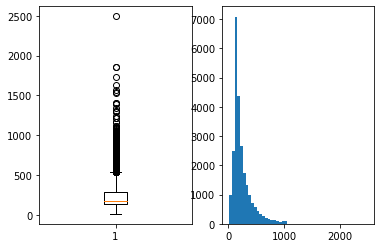

In [50]:
len_result = [len(s) for s in X_train]

print('Maximum length of reviews : {}'.format(np.max(len_result)))
print('Average length of reviews : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

## Data를 읽을 수 있는 형태로 표현하기.
인코딩된 Data는 사람이 읽기 힘들다. 정수로 표현된 단어를 단어 그 자체로 변환해주는 사전을 Keras에서 제공한다. 이 사전을 이용해서 정수 -> 단어로 변환해본다.

In [51]:
word_idx = imdb.get_word_index()
word_dict = {}

word_dict = dict((i, word) for (word, i) in word_idx.items())

# for key, value in word_idx.items():
#     word_dict[value+3] = key

print("사용 빈도 상위 15 단어들 : ")

for i in range(1,16):
    print(str(i) + "번째 빈도 : " + word_dict[i])

사용 빈도 상위 15 단어들 : 
1번째 빈도 : the
2번째 빈도 : and
3번째 빈도 : a
4번째 빈도 : of
5번째 빈도 : to
6번째 빈도 : is
7번째 빈도 : br
8번째 빈도 : in
9번째 빈도 : it
10번째 빈도 : i
11번째 빈도 : this
12번째 빈도 : that
13번째 빈도 : was
14번째 빈도 : as
15번째 빈도 : for


그럼 가장 안쓰이는 단어는 무엇일까?

In [52]:
print("사용 빈도 하위 15 단어들 : ")

len(word_dict)
for i in range(1,16):
    
    print(str(i) + "번째 빈도 : "+ word_dict[len(word_dict)-(i)])

사용 빈도 하위 15 단어들 : 
1번째 빈도 : voorhees'
2번째 빈도 : artbox
3번째 빈도 : copywrite
4번째 빈도 : pipe's
5번째 빈도 : wheelers
6번째 빈도 : sics
7번째 빈도 : transacting
8번째 빈도 : chicatillo
9번째 빈도 : ev
10번째 빈도 : urrrghhh
11번째 빈도 : airsoft
12번째 빈도 : nemesis'
13번째 빈도 : guard's
14번째 빈도 : 'solve'
15번째 빈도 : odilon


## Index 사전을 이용해서 Data를 사람이 읽을 수 있는 문장으로 만들기

In [53]:
X_train[0]

X_phrase = []
X_str = ""

print(X_train[6])
for integer in X_train[6]:
    X_str = X_str + " " + word_dict[integer]
    X_phrase.append(word_dict[integer])

# print(X_phrase)
print(X_str)

# # 아래는 Keras에서 Demo로 구현한 Vect -> Word 변환 코드임.

# # Retrieve the training sequences.
# (x_train, _), _ = imdb.load_data()
# # Retrieve the word index file mapping words to indices
# word_index = imdb.get_word_index()
# # Reverse the word index to obtain a dict mapping indices to words
# inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# # Decode the first sequence in the dataset
# decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])

[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 10626, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 16393, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 71690, 4183, 17, 369, 37, 215, 1345, 143, 32677, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 26441, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 74170, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 33740, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 77842, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
 the boiled full involving to impressive boring this as murdering naschy br villain council suggestion need has of costumes b message to may of props this echoed concentrates concept issue skeptical to god's he is dedications unfolds movie women like isn't surely i'm rocketed to toward in here's for from did having because very quality it is captain's starship really book is both too worked carl of mayfair br of reviewer c

## 본격적으로 RNN 디자인 시작하기.

### Vanilla RNN
Vanilla RNN은 아무것도 첨가하지 않은 RNN이라고 한다. 따라서 Tensorflow나 다른 인공신경망 API를 사용할 때, RNN을 활용하면 된다. 과제에서 처음 문항은 이런 Vanilla RNN을 활용하여 어느 정도 긍/부정 분류가 가능한 신경망을 학습하라고 지시하였다. 이를 위해서 RNN 설계를 진행하려고 한다.

In [54]:
import re
import tensorflow as tf

max_voca = 8000

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words = max_voca)

c:\users\bong\project\dgist-rt626\.rt626\hw2\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\bong\project\dgist-rt626\.rt626\hw2\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


이 notebook의 상단의 Data 가공 예제와 다르게 단어 사전의 크기를 10000으로 제한했다. 이로써 정말 잘 쓰이지 않는 단어를 삭제하므로써 overfitting되는 것을 방지할 수 있을 것으로 예상했다.

In [55]:
max_len = 200
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, max_len)

과제를 진행하는 PC의 성능이 좋다면 큰 크기의 Network를 사용할 수 있을 것이다. 하지만, 현재 과제를 진행하는 컴퓨터의 성능이 썩좋지 못하여 처리하는 문장의 크기 또한 축소했다.

### Design Policy 확인하기
이번 과제에서 학습할 RNN의 모델에 대해서 생각해보자. 이번에 설계해야할 NN은 Many to One 디자인이다. 왜냐하면, 문장(여러 단어)를 입력받아 긍정 부정인 Binary(R1 공간)의 정보로 변환되기 때문이다.

![m2o_img](readme/computational-graph-many-to-one.png)

여기서 우리는 각 문장의 크기를 500으로 padding 시켰기 때문에 RNN의 입력 Layer의 구성은 쉽게 만들 수 있다.

In [56]:
embedding_size = 32

vanilla_model = tf.keras.Sequential()

vanilla_model.add(tf.keras.layers.Embedding(max_voca, 100))
vanilla_model.add(tf.keras.layers.SimpleRNN(128))
vanilla_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

print(vanilla_model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,029,441
Trainable params: 1,029,441
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
GRU_model = tf.keras.Sequential()
GRU_model.add(tf.keras.layers.Embedding(max_voca,128))
GRU_model.add(tf.keras.layers.GRU(128))
GRU_model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

print(GRU_model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 1,379,201
Trainable params: 1,379,201
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(max_voca,128))
LSTM_model.add(tf.keras.layers.LSTM(128))
LSTM_model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

print(LSTM_model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________
None


## 학습 종료 조건, 학습 업데이트 조건 정의

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('simpleRNN.h5', monitor='val_acc', mode='max', save_best_only=True)

## 학습 모델 컴파일과 학습 시작
Vanilla RNN 모델 학습하기

In [32]:
vanilla_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = vanilla_model.fit(X_train, y_train, epochs=5, batch_size=2048, validation_split=0.2)

Epoch 1/5
10/10 [==============================] - 8s 848ms/step - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0066 - val_acc: 0.9992
Epoch 2/5
10/10 [==============================] - 8s 812ms/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0057 - val_acc: 0.9984
Epoch 3/5
10/10 [==============================] - 9s 883ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 4/5
10/10 [==============================] - 8s 849ms/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0052 - val_acc: 0.9984
Epoch 5/5
10/10 [==============================] - 9s 889ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0058 - val_acc: 0.9982


GRU RNN 모델 학습하기

In [20]:
GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_GRU = GRU_model.fit(X_train, y_train, epochs=5, batch_size=2048, validation_split=0.2)

Epoch 1/5
10/10 [==============================] - 6s 577ms/step - loss: 0.6894 - acc: 0.5637 - val_loss: 0.6820 - val_acc: 0.6008
Epoch 2/5
10/10 [==============================] - 5s 535ms/step - loss: 0.6549 - acc: 0.6785 - val_loss: 0.6114 - val_acc: 0.6848
Epoch 3/5
10/10 [==============================] - 5s 534ms/step - loss: 0.5045 - acc: 0.7688 - val_loss: 0.5174 - val_acc: 0.7450
Epoch 4/5
10/10 [==============================] - 5s 525ms/step - loss: 0.4139 - acc: 0.8191 - val_loss: 0.4474 - val_acc: 0.8204
Epoch 5/5
10/10 [==============================] - 5s 526ms/step - loss: 0.3064 - acc: 0.8705 - val_loss: 0.3826 - val_acc: 0.8298


LSTM 모델 학습하기

In [61]:
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_LSTM = LSTM_model.fit(X_train, y_train, epochs=10, batch_size=512, validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 97s 2s/step - loss: 0.5359 - acc: 0.7141 - val_loss: 0.3522 - val_acc: 0.8586
Epoch 2/30
40/40 [==============================] - 85s 2s/step - loss: 0.2779 - acc: 0.8942 - val_loss: 0.3606 - val_acc: 0.8622
Epoch 3/30
40/40 [==============================] - 84s 2s/step - loss: 0.1972 - acc: 0.9269 - val_loss: 0.3182 - val_acc: 0.8744
Epoch 4/30
40/40 [==============================] - 85s 2s/step - loss: 0.1384 - acc: 0.9521 - val_loss: 0.3365 - val_acc: 0.8724
Epoch 5/30
40/40 [==============================] - 85s 2s/step - loss: 0.1083 - acc: 0.9651 - val_loss: 0.3621 - val_acc: 0.8660
Epoch 6/30
40/40 [==============================] - 87s 2s/step - loss: 0.0956 - acc: 0.9686 - val_loss: 0.3477 - val_acc: 0.8572
Epoch 7/30
40/40 [==============================] - 93s 2s/step - loss: 0.0941 - acc: 0.9691 - val_loss: 0.5046 - val_acc: 0.8644
Epoch 8/30
40/40 [==============================] - 87s 2s/step - loss: 0.0567 - acc: 0.98

KeyboardInterrupt: 

## 학습 결과 Plot 하기
Vanilla 모델의 학습 결과

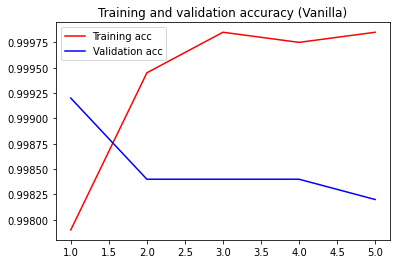

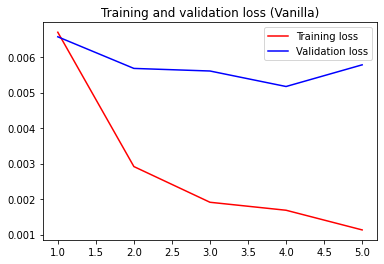

196/196 [==============================] - 20s 102ms/step - loss: 1.5086 - acc: 0.7718
test loss, test acc: [1.508592963218689, 0.77183997631073]


In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy (Vanilla)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and validation loss (Vanilla)')
plt.legend()
plt.show()

results = vanilla_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

GRU 모델의 학습 결과

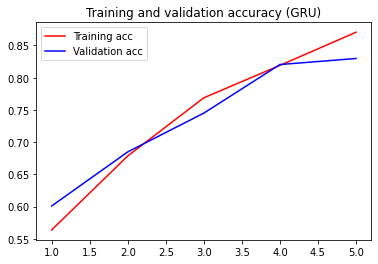

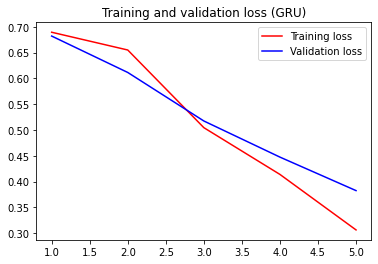

196/196 [==============================] - 8s 40ms/step - loss: 0.3762 - acc: 0.8361
test loss, test acc: [0.37623199820518494, 0.836080014705658]


In [21]:
acc = history_GRU.history['acc']
val_acc = history_GRU.history['val_acc']
loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy (GRU)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and validation loss (GRU)')
plt.legend()
plt.show()

results = GRU_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

LSTM 모델의 학습 결과

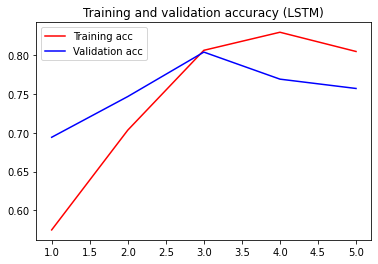

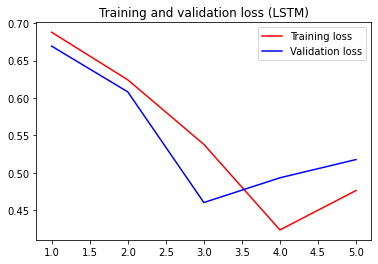

196/196 [==============================] - 8s 42ms/step - loss: 0.5170 - acc: 0.7662
test loss, test acc: [0.5169534683227539, 0.7662400007247925]


In [19]:
acc = history_LSTM.history['acc']
val_acc = history_LSTM.history['val_acc']
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy (LSTM)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and validation loss (LSTM)')
plt.legend()
plt.show()

results = LSTM_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)